<a href="https://colab.research.google.com/github/nandhiniswaminathan/face-recognition/blob/master/Correct_copy_of_fer_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import warnings
import sys, os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
import tensorflow as tf
import tensorflow.contrib.eager as tfe
warnings.filterwarnings("ignore")

#data = pd.DataFrame(downloaded.items(), columns=['emotion', 'pixels'])

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
tf.enable_eager_execution()

In [3]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 134443 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.17-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.17-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.17-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [6]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
# mount Google drive
!mkdir -p drive
!google-drive-ocamlfuse drive -o nonempty
basepath = "/content/drive/Colab Notebooks"
sys.path.insert(0, basepath)
os.chdir(basepath)

In [0]:
# define file paths
datafile = './fer2013.csv'

In [0]:
# initialize parameters
width, height = 48, 48
num_epochs = 50
batch_size = 64
dropout_rate = 0.3


In [0]:
# read data
data = pd.read_csv(datafile)

In [12]:
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [13]:
# convert strings to lists of integers
data['pixels'] = data['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
emotion_map = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
emotion_counts = data['emotion'].value_counts().reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Happy,8989
1,Neutral,6198
2,Sad,6077
3,Fear,5121
4,Angry,4953
5,Surprise,4002
6,Disgust,547


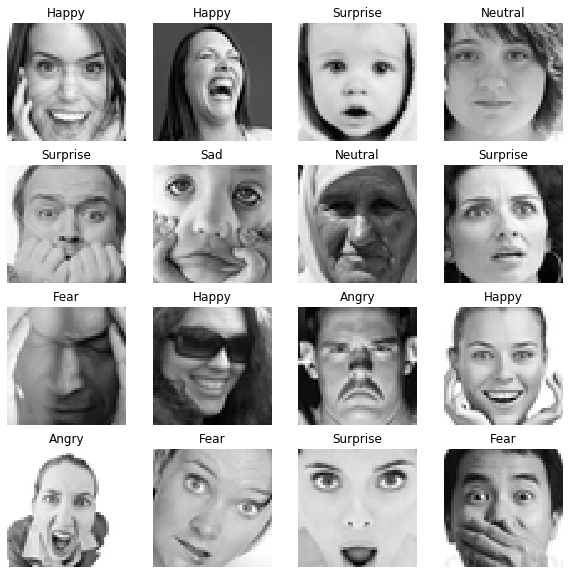

In [14]:
random_seed = 8
# randomly select 16 images
image_sample = data.sample(16, random_state=random_seed)

# Create subplots for images
_, axs = plt.subplots(4, 4, figsize=(10,10))
axs = axs.ravel()
i = 0
for _, row in image_sample.iterrows():
    one_image = np.array(row['pixels']).reshape(width,height)
    axs[i].imshow(one_image, cmap='gray')
    axs[i].set_title(emotion_map[row['emotion']])
    axs[i].axis('off')
    i += 1

In [76]:
from keras.utils import to_categorical
# training data
data_train = data[data['Usage']=='Training']
# reshape image data (num of images, width, height, num of channels)
x_train = np.array(data_train['pixels'].tolist(), dtype='float32').reshape(-1,width,height,1)/255.
# get labels
y_train = keras.utils.to_categorical(data_train['emotion'].as_matrix())

# validation data
data_val = data[data['Usage']!='Training']
# reshape image data (num of images, width, height, num of channels)
x_val = np.array(data_val['pixels'].tolist(), dtype='float32').reshape(-1,width,height,1)/255.
# get labels
y_val =keras.utils.to_categorical( data_val['emotion'].as_matrix())

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((28709, 48, 48, 1), (28709, 7), (7178, 48, 48, 1), (7178, 7))

In [16]:
import sys, os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model

Using TensorFlow backend.


In [0]:
# convert numpy arrays to tf tensors
training_tf = tf.data.Dataset.from_tensor_slices((x_train, y_train[:,None])).batch(batch_size)
val_tf = tf.data.Dataset.from_tensor_slices((x_val, y_val[:,None])).batch(batch_size)

In [19]:
from keras.utils import to_categorical
model = Sequential()
num_features = 64
num_labels = 7
batch_size = 64
tf.compat.v1.disable_eager_execution()














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
#execute cell later model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 23, 23, 128)      

In [0]:
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [0]:
MODELPATH ='./fer2013.csv'
checkpointer = ModelCheckpoint(MODELPATH, monitor='val_loss', verbose=1, save_best_only=True)

In [0]:
pip install tf-nightly-gpu

In [77]:
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt

model = Sequential()

#1st convolution layer
model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))

#2nd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

#3rd convolution layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

model.add(Flatten())

#fully connected neural networks
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_labels, activation='softmax'))
model.summary()
#------------------------------
#batch process
gen = ImageDataGenerator()
train_generator = gen.flow(x_train, y_train, batch_size=batch_size)

#------------------------------

model.compile(loss='categorical_crossentropy'
    , optimizer=keras.optimizers.Adam()
    , metrics=['accuracy']
)

#------------------------------

fit = True
from sklearn.preprocessing import OneHotEncoder

if fit == True:
	#model.fit_generator(x_train, y_train, epochs=epochs) #train for all trainset
	model.fit_generator(train_generator, steps_per_epoch=batch_size, epochs=epochs ) #train for randomly selected one
else:
	model.load_weights('/data/facial_expression_model_weights.h5') #load weights
	
#------------------------------
"""
#overall evaluation
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', 100*score[1])
"""
#------------------------------
#function for drawing bar chart for emotion preditions
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()
#------------------------------

monitor_testset_results = False

if monitor_testset_results == True:
	#make predictions for test set
	predictions = model.predict(x_test)

	index = 0
	for i in predictions:
		if index < 30 and index >= 20:
			#print(i) #predicted scores
			#print(y_test[index]) #actual scores
			
			testing_img = np.array(x_test[index], 'float32')
			testing_img = testing_img.reshape([48, 48]);
			
			plt.gray()
			plt.imshow(testing_img)
			plt.show()
			
			print(i)
			
			emotion_analysis(i)
			print("----------------------------------------------")
		index = index + 1

#------------------------------
#make prediction for custom image out of test set



Epoch 1/50
64/64 [==============================] - 32s 502ms/step - loss: 1.8267 - acc: 0.2478
Epoch 2/50
64/64 [==============================] - 30s 462ms/step - loss: 1.8108 - acc: 0.2478
Epoch 3/50
64/64 [==============================] - 30s 462ms/step - loss: 1.8153 - acc: 0.2451
Epoch 4/50
64/64 [==============================] - 29s 459ms/step - loss: 1.8142 - acc: 0.2532
Epoch 5/50
64/64 [==============================] - 30s 462ms/step - loss: 1.8327 - acc: 0.2461
Epoch 6/50
64/64 [==============================] - 29s 449ms/step - loss: 1.8125 - acc: 0.2573
Epoch 7/50
64/64 [==============================] - 29s 448ms/step - loss: 1.8132 - acc: 0.2524
Epoch 8/50
64/64 [==============================] - 29s 451ms/step - loss: 1.8042 - acc: 0.2590
Epoch 9/50
64/64 [==============================] - 29s 450ms/step - loss: 1.8229 - acc: 0.2456
Epoch 10/50
64/64 [==============================] - 29s 452ms/step - loss: 1.8085 - acc: 0.2498
Epoch 11/50
64/64 [====================

FileNotFoundError: ignored

MessageError: ignored

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


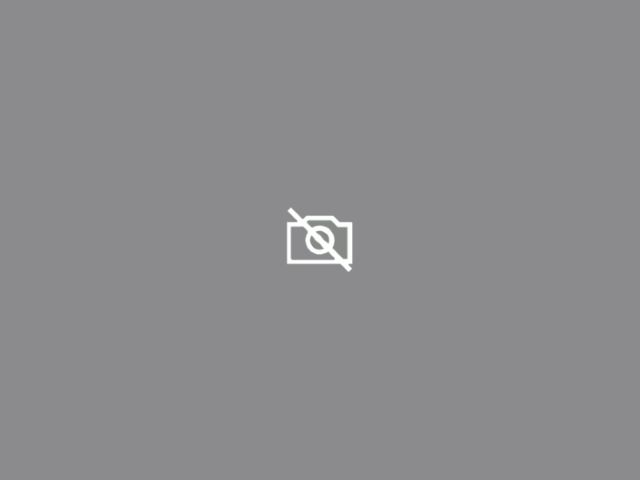

In [83]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

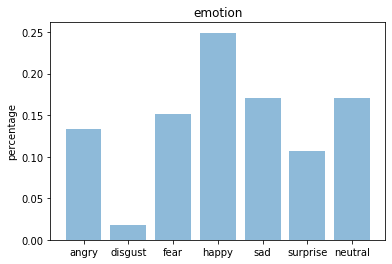

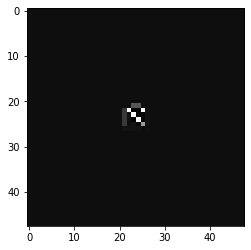

In [84]:
img = image.load_img("photo.jpg", grayscale=True, target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(x)
plt.show()